In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Decision Tree

In [ ]:
def entropy(y):
    hist = np.bincount(y)
    ps = hist / len(y)
    return -np.sum([p * np.log2(p) for p in ps if p > 0])

def gini(y):
    unique,label_count = np.unique(y,return_counts = True)
    ps = label_count/np.sum(label_count)
    return 1 - np.sum(ps**2)


class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None


class DecisionTree:
    def __init__(self, criteria, min_samples_split=2, max_depth=100, n_feats=None):
        self.criteria = criteria
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.root = None

    def fit(self, X, y):
        self.n_feats = X.shape[1] if not self.n_feats else min(self.n_feats, X.shape[1])
        self.root = self._grow_tree(X, y)

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        # stopping criteria
        if (
            depth >= self.max_depth
            or n_labels == 1
            or n_samples < self.min_samples_split
            or y.size == 0 
            or n_samples == 0
        ):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_features, self.n_feats, replace=False)

        # greedily select the best split according to information gain
        best_feat, best_thresh = self._best_criteria(X, y, feat_idxs)

        # grow the children that result from the split
        left_idxs, right_idxs = self._split(X[:, best_feat], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth + 1)
        return Node(best_feat, best_thresh, left, right)

    def _best_criteria(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_thresh = None, None
        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            #thresholds = np.unique(X_column)
            thresholds = np.linspace(0,1,100)
            for threshold in thresholds:
                gain = self._information_gain(y, X_column, threshold)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_thresh = threshold

        return split_idx, split_thresh

    def _information_gain(self, y, X_column, split_thresh):
        # parent loss
        parent_impurity = self.criteria(y)

        # generate split
        left_idxs, right_idxs = self._split(X_column, split_thresh)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0

        # compute the weighted avg. of the loss for the children
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = self.criteria(y[left_idxs]), self.criteria(y[right_idxs])
        child_impurity = (n_l / n) * e_l + (n_r / n) * e_r

        # information gain is difference in loss before vs. after split
        ig = parent_impurity - child_impurity
        return ig

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

    def _most_common_label(self, y):
        unique,class_count = np.unique(y,return_counts=True)
        most_common = unique[np.argmax(class_count)]
        return most_common



## Random Forest

In [ ]:
def bootstrap_sample(X, y):
    n_samples = X.shape[0]
    idxs = np.random.choice(n_samples, n_samples, replace=True)
    return X[idxs], y[idxs]

class RandomForest:
    def __init__(self,n_trees=10, min_samples_split=2, max_depth=100, n_feats=None):
        self.n_trees = n_trees
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            tree = DecisionTree(criteria = gini,min_samples_split=self.min_samples_split,max_depth=self.max_depth, n_feats=self.n_feats)
            X_samp, y_samp = bootstrap_sample(X, y)
            tree.fit(X_samp, y_samp)
            self.trees.append(tree)

    def _most_common_label(self, y):
        unique,class_count = np.unique(y,return_counts=True)
        # print("y")
        # print(y)
        most_common = unique[np.argmax(class_count)]
        return most_common

    def predict(self, X):
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        tree_preds = np.swapaxes(tree_preds, 0, 1)
        y_pred = [self._most_common_label(tree_pred) for tree_pred in tree_preds]
        return np.array(y_pred)


In [ ]:
# Plotting Confusion Matrix
def plot_confusion_matrix(data, labels, classifier):
    import seaborn
    seaborn.set(color_codes=True)
    plt.figure(1, figsize=(7,7))
 
    plt.title("Confusion Matrix for {}".format(classifier))
 
    seaborn.set(font_scale=1)
    ax = seaborn.heatmap(data, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Scale'}, fmt='g')
 
    ax.set_xticklabels(labels.astype(int))
    ax.set_yticklabels(labels.astype(int))
 
    ax.set(ylabel="True Label", xlabel="Predicted Label")

    plt.show()

# calculating Confusion Matrix and F1 Scores
def confusion_matrix_and_F1_score(y_pred,y_true):
  num_classes = len(np.unique(y_true))
  first_label = int(np.min(y_true))

  # initialize confusion matrix with zeros
  confusion_matrix = np.zeros((num_classes+first_label, num_classes+first_label))

  # loop over all samples
  for i in range(len(y_true)):
      # increment count of true-predicted label pair
      confusion_matrix[int(y_true[i]), int(y_pred[i])] += 1

  confusion_matrix = confusion_matrix[first_label:,first_label:]
  #plot_confusion_matrix(confusion_matrix, np.unique(y_true))


  # calculate precision, recall, and F1 score for each class
  class_precision = np.zeros(num_classes)
  class_recall = np.zeros(num_classes)
  class_f1 = np.zeros(num_classes)
  for i in range(num_classes):
      class_precision[i] = confusion_matrix[i,i] / np.sum(confusion_matrix[:,i])
      class_recall[i] = confusion_matrix[i,i] / np.sum(confusion_matrix[i,:])
      class_f1[i] = 2 * (class_precision[i] * class_recall[i]) / (class_precision[i] + class_recall[i])
  return confusion_matrix , class_f1



# Data

In [ ]:
kmnist_pca = np.genfromtxt("/content/drive/MyDrive/PRNN/PCA_MNIST.csv", delimiter=",", dtype=float)
l = kmnist_pca[1:,:][:,0]
t  =kmnist_pca[1:,:][:,1:]
kmnist_pca = np.column_stack((t,l))

In [ ]:
### Normalizing Data
for i in range(10):
  kmnist_pca[:,i] = (kmnist_pca[:,i] - np.min(kmnist_pca[:,i]))/(np.max(kmnist_pca[:,i])-np.min(kmnist_pca[:,i]))

In [ ]:
Q1_X_train_1,Q1_y_train_1 = kmnist_pca[0:42000,:-1] , kmnist_pca[0:42000,-1].astype(int)#.reshape(-1,1).astype(int)
Q1_X_test_1, Q1_y_test_1 = kmnist_pca[42000:,:-1],kmnist_pca[42000:,-1].astype(int)#.reshape(-1,1).astype(int)

# Q1

## PCA KMNIST Dataset

In [ ]:
clf = DecisionTree(criteria = gini,max_depth=10)
clf.fit(Q1_X_train_1, Q1_y_train_1)
y_pred_gini = clf.predict(Q1_X_test_1)

## Accuracy for Gini Impurity

In [ ]:
np.mean(y_pred_gini==Q1_y_test_1)

0.9131666666666667

## Confusion Matrix (Gini)

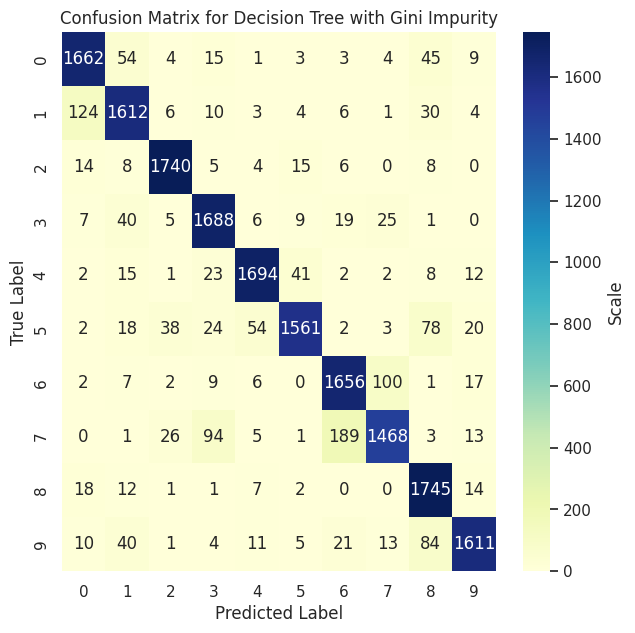

In [ ]:
Q1_confusion_matrix_gini_1, Q1_F1_score_gini_1 = confusion_matrix_and_F1_score(y_pred_gini, Q1_y_test_1)

plot_confusion_matrix(Q1_confusion_matrix_gini_1, np.unique(Q1_y_test_1), "Decision Tree with Gini Impurity")


## Entropy

In [ ]:
clf = DecisionTree(criteria = entropy,max_depth=10)
clf.fit(Q1_X_train_1, Q1_y_train_1)
y_pred_entropy = clf.predict(Q1_X_test_1)

### Accuracy for Entropy

In [ ]:
np.mean(y_pred_entropy == Q1_y_test_1)

0.9162777777777777

## Confusion Matrix (entropy)

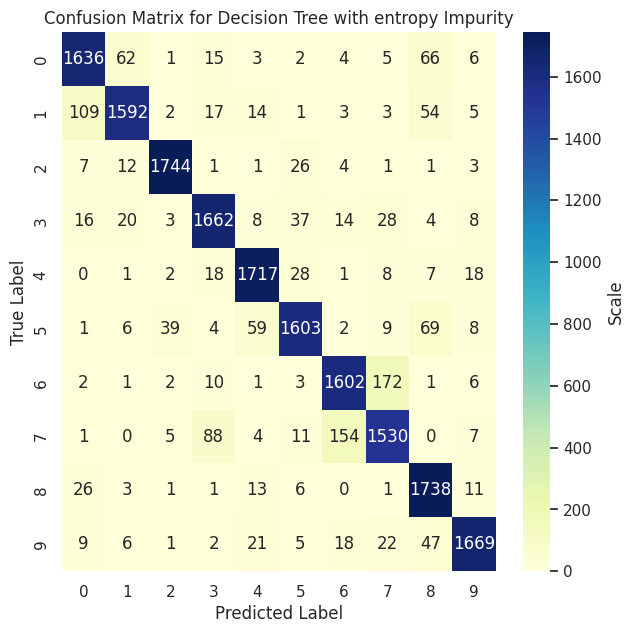

In [ ]:
Q1_confusion_matrix_entropy_1, Q1_F1_score_entropy_1 = confusion_matrix_and_F1_score(y_pred_entropy, Q1_y_test_1)

plot_confusion_matrix(Q1_confusion_matrix_entropy_1, np.unique(Q1_y_test_1), "Decision Tree with entropy Impurity")


### P3 Data Set

In [ ]:
p3_train =  np.genfromtxt("/content/drive/MyDrive/PRNN/p3_train.csv", delimiter=",", dtype=float) 
p3_test =  np.genfromtxt("/content/drive/MyDrive/PRNN/p3_test.csv", delimiter=",", dtype=float) 


In [ ]:
for i in range(10):
  p3_train[:,i] = (p3_train[:,i] - np.min(p3_train[:,i]))/(np.max(p3_train[:,i])-np.min(p3_train[:,i]))
  p3_test[:,i] = (p3_test[:,i] - np.min(p3_test[:,i]))/(np.max(p3_test[:,i])-np.min(p3_test[:,i]))

In [ ]:
Q1_X_train_2,Q1_y_train_2 = p3_train[:,:-1] , p3_train[:,-1].astype(int)#.reshape(-1,1).astype(int)
Q1_X_test_2, Q1_y_test_2 = p3_test[:,:-1],p3_test[:,-1].astype(int)#.reshape(-1,1).astype(int)

## Entropy

In [ ]:
clf = DecisionTree(criteria = entropy, max_depth=10)
clf.fit(Q1_X_train_2, Q1_y_train_2)
y_pred_entropy = clf.predict(Q1_X_test_2)

## Accuracy for Entropy

In [ ]:
np.mean(y_pred_entropy==Q1_y_test_2)

0.5513333333333333

## Confusion Matrix (Entropy)

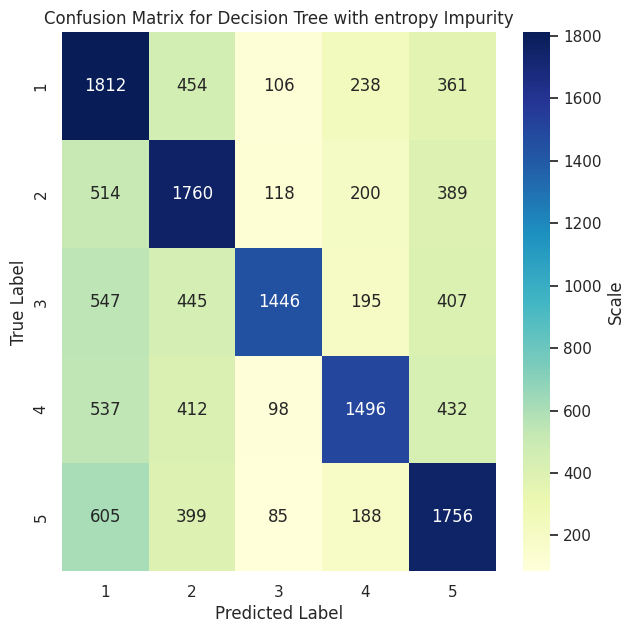

In [ ]:
Q1_confusion_matrix_entropy_2, Q1_F1_score_entropy_2 = confusion_matrix_and_F1_score(y_pred_entropy, Q1_y_test_2)

plot_confusion_matrix(Q1_confusion_matrix_entropy_2, np.unique(Q1_y_test_2), "Decision Tree with entropy Impurity")


## Gini

In [ ]:
clf = DecisionTree(criteria = gini, max_depth=10)
clf.fit(Q1_X_train_2, Q1_y_train_2)
y_pred_gini = clf.predict(Q1_X_test_2)

## Accuracy for gini

In [ ]:
np.mean(y_pred_gini==Q1_y_test_2)

0.5476666666666666

## Confusion Matrix (gini)

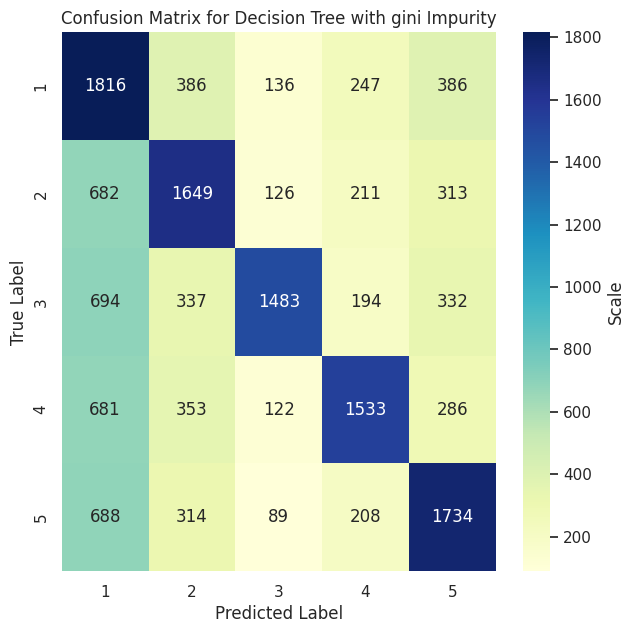

In [ ]:

Q1_confusion_matrix_gini_2, Q1_F1_score_gini_2 = confusion_matrix_and_F1_score(y_pred_gini, Q1_y_test_2)

plot_confusion_matrix(Q1_confusion_matrix_gini_2, np.unique(Q1_y_test_2), "Decision Tree with gini Impurity")

In [ ]:
def depth_vs_acc(criteria,depth,x_train,y_train,x_test,y_test):
    acc = []
    for i in range(1,depth+1):
        clf = DecisionTree(criteria = criteria,max_depth=i)
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)
        acc.append(np.mean(y_pred == y_test))

    return acc

## Accuracy vs Depth of Decision Tree plot for PCA KMNIST Dataset

In [ ]:
acc = depth_vs_acc(entropy,15,Q1_X_train_1,Q1_y_train_1,Q1_X_test_1,Q1_y_test_1)

Text(0.5, 1.0, 'Accuracy vs Depth (PCA KMNIST)')

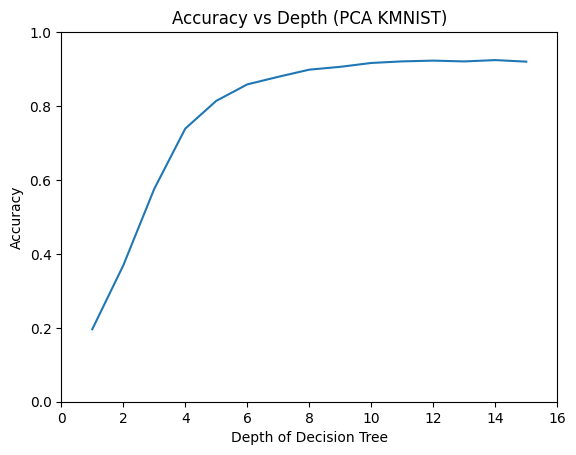

In [ ]:
plt.plot(np.arange(1,16),acc)
plt.xlim([0, 16])
plt.ylim([0, 1])
plt.xlabel("Depth of Decision Tree")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Depth (PCA KMNIST)")

## Accuracy vs Depth of Decision Tree plot for P3 Dataset

In [ ]:
acc1 = depth_vs_acc(gini,15,Q1_X_train_2,Q1_y_train_2,Q1_X_test_2,Q1_y_test_2)

Text(0.5, 1.0, 'Accuracy vs Depth (P3 Dataset)')

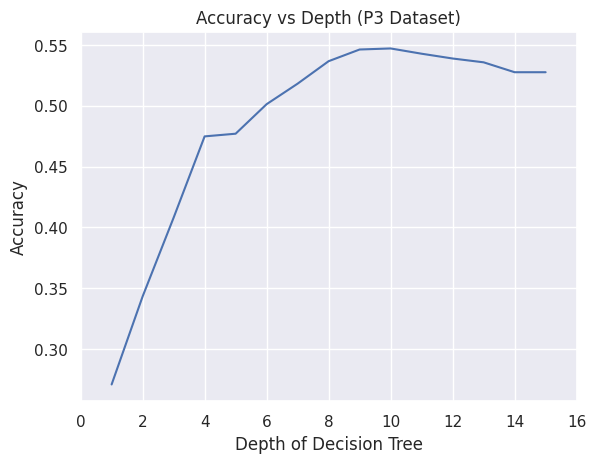

In [ ]:
plt.plot(np.arange(1,16),acc1)
plt.xlabel("Depth of Decision Tree")
plt.xlim([0, 16])
# plt.ylim([0, 1])
plt.ylabel("Accuracy")
plt.title("Accuracy vs Depth (P3 Dataset)")

# Q2

## For PCA KMNIST

In [ ]:
clf = RandomForest(n_trees=5, max_depth=10,n_feats=3)
clf.fit(Q1_X_train_1, Q1_y_train_1)
y_pred = clf.predict(Q1_X_test_1)

In [ ]:
clf2 = RandomForest(n_trees=5, max_depth=10,n_feats=3)
clf.fit(Q1_X_train_2, Q1_y_train_2)
y_pred2 = clf.predict(Q1_X_test_2)

## Confusion Matrix and F1 Scores

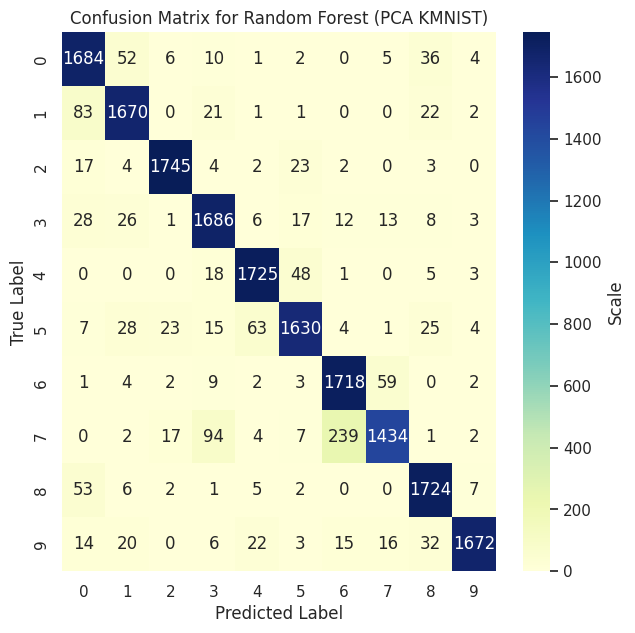

In [ ]:
Q2_confusion_matrix, Q2_F1_score = confusion_matrix_and_F1_score(y_pred, Q1_y_test_1)

plot_confusion_matrix(Q2_confusion_matrix, np.unique(Q1_y_test_1), "Random Forest (PCA KMNIST)")

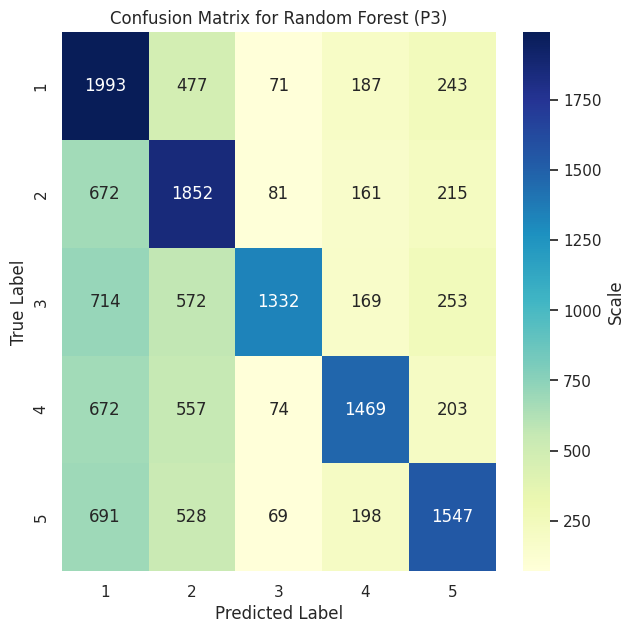

In [ ]:
Q2_confusion_matrix2, Q2_F1_score2 = confusion_matrix_and_F1_score(y_pred2, Q1_y_test_2)

plot_confusion_matrix(Q2_confusion_matrix2, np.unique(Q1_y_test_2), "Random Forest (P3)")

In [ ]:
from tabulate import tabulate
Q2_F1_scores = [["Random Forest (PCA KMNIST)",Q2_F1_score],["Random Forest (P3)",Q2_F1_score2]]
headers = [" ", "F1_scores"]
print(tabulate(Q2_F1_scores, headers, tablefmt="fancy_grid"))

╒════════════════════════════╤═══════════════════════════════════════════════════════════════════╕
│                            │ F1_scores                                                         │
╞════════════════════════════╪═══════════════════════════════════════════════════════════════════╡
│ Random Forest (PCA KMNIST) │ [0.91347979 0.92469546 0.9705228  0.92030568 0.95015147 0.9219457 │
│                            │  0.90635716 0.86177885 0.94310722 0.95570163]                     │
├────────────────────────────┼───────────────────────────────────────────────────────────────────┤
│ Random Forest (P3)         │ [0.51678984 0.5316492  0.57081637 0.56949021 0.56315981]          │
╘════════════════════════════╧═══════════════════════════════════════════════════════════════════╛


## Number of Decision Trees vs Accuracy Plot

In [ ]:
clf = RandomForest(n_trees=3, max_depth=10,n_feats=3)
clf.fit(Q1_X_train_1, Q1_y_train_1)
y_pred = clf.predict(Q1_X_test_1)

In [ ]:
acc_trees = []
for i in range(1, 20):
  clf = RandomForest(n_trees = i, max_depth=10, n_feats=10)
  clf.fit(Q1_X_train_1, Q1_y_train_1)
  y_pred = clf.predict(Q1_X_test_1)
  acc_trees.append(np.mean(y_pred==Q1_y_test_1))


Text(0.5, 1.0, 'Accuracy vs Number of Decision Trees (PCA KMNIST)')

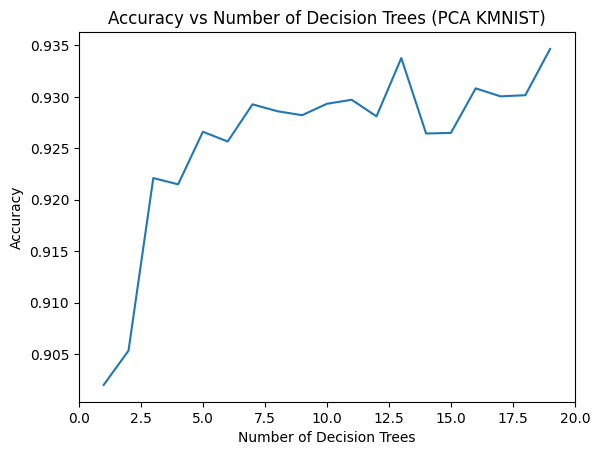

In [ ]:
plt.plot(np.arange(1,20),acc_trees)
plt.xlabel("Number of Decision Trees")
plt.xlim([0, 20])
# plt.ylim([0, 1])
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number of Decision Trees (PCA KMNIST)")

## Number of Features vs Accuracy plot

In [ ]:
acc_features = []
for i in range(2, 10):
  print(i)
  clf = RandomForest(n_trees = 5, max_depth=10, n_feats=i)
  clf.fit(Q1_X_train_1, Q1_y_train_1)
  y_pred = clf.predict(Q1_X_test_1)
  acc_features.append(np.mean(y_pred==Q1_y_test_1))

Text(0.5, 1.0, 'Accuracy vs Number of Features (PCA KMNIST)')

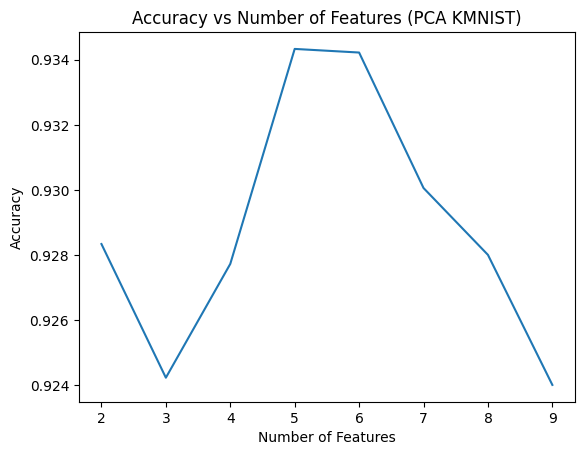

In [ ]:
plt.plot(np.arange(2,10),acc_features)
plt.xlabel("Number of Features")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number of Features (PCA KMNIST)")

In [ ]:
acc_features = []
for i in range(2, 10):
  print(i)
  clf = RandomForest(n_trees = 8, max_depth=10, n_feats=i)
  clf.fit(Q1_X_train_1, Q1_y_train_1)
  y_pred = clf.predict(Q1_X_test_1)
  acc_features.append(np.mean(y_pred==Q1_y_test_1))

Text(0.5, 1.0, 'Accuracy vs Number of Features (PCA KMNIST)')

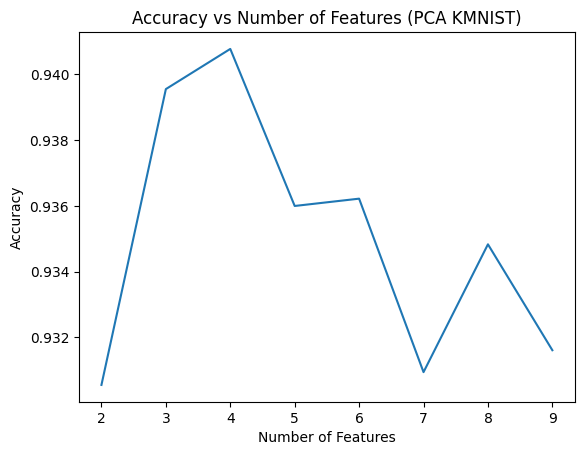

In [ ]:
plt.plot(np.arange(2,10),acc_features)
plt.xlabel("Number of Features")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number of Features (PCA KMNIST)")

## For P3 Dataset

## Number of Decision Trees vs Accuracy Plot

In [ ]:
acc_trees2 = []
for i in range(1, 20):
  clf = RandomForest(n_trees=i, max_depth=10, n_feats=4)
  clf.fit(Q1_X_train_2, Q1_y_train_2)
  y_pred = clf.predict(Q1_X_test_2)
  acc_trees2.append(np.mean(y_pred==Q1_y_test_2))


Text(0.5, 1.0, 'Accuracy vs Number of Decision Trees (P3)')

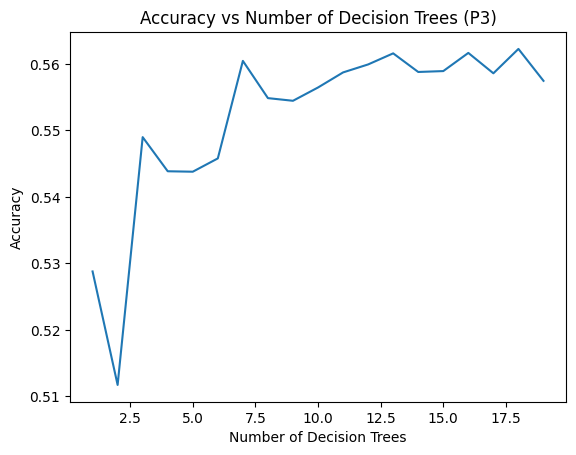

In [ ]:
plt.plot(np.arange(1,20),acc_trees2)
plt.xlabel("Number of Decision Trees")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number of Decision Trees (P3)")

## Number of Features vs Accuracy plot

In [ ]:
acc_features2 = []
for i in range(3, 10):
  print(i)
  clf = RandomForest(n_trees = 8, max_depth=10, n_feats=i)
  clf.fit(Q1_X_train_2, Q1_y_train_2)
  y_pred = clf.predict(Q1_X_test_2)
  acc_features2.append(np.mean(y_pred==Q1_y_test_2))

3
4
5
6
7
8
9


Text(0.5, 1.0, 'Accuracy vs Number of Decision Trees (P3)')

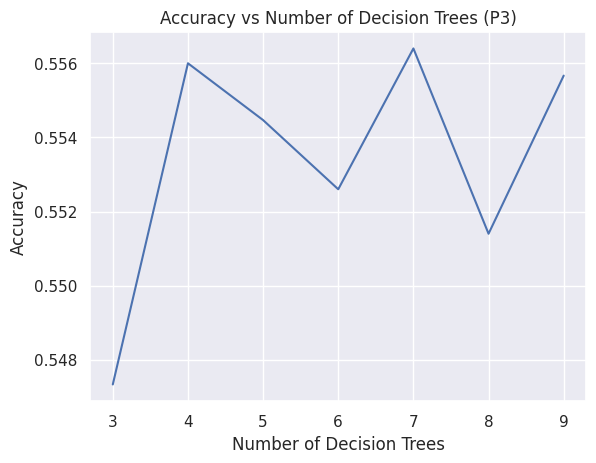

In [ ]:
plt.plot(np.arange(3,10),acc_features2)
plt.xlabel("Number of Decision Trees")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number of Decision Trees (P3)")

In [ ]:
acc_features2 = []
for i in range(3, 10):
  print(i)
  clf = RandomForest(n_trees = 8, max_depth=10, n_feats=i)
  clf.fit(Q1_X_train_1, Q1_y_train_2)
  y_pred = clf.predict(Q1_X_test_2)
  acc_features2.append(np.mean(y_pred==Q1_y_test_2))

3
4
5
6
7
8
9


Text(0.5, 1.0, 'Accuracy vs Number of Decision Trees (P3)')

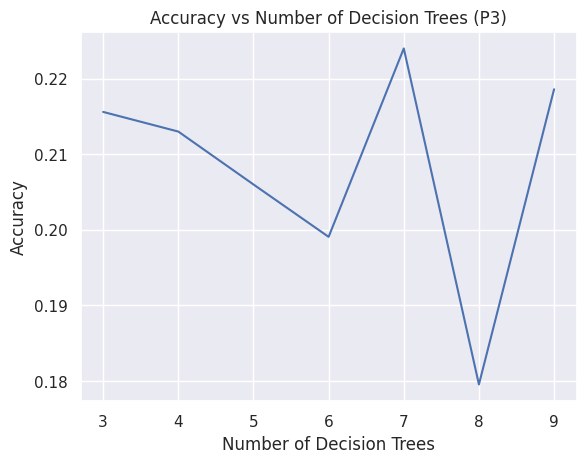

In [ ]:
plt.plot(np.arange(3,10),acc_features2)
plt.xlabel("Number of Decision Trees")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number of Decision Trees (P3)")

## Q3 

In [ ]:
def entropy(y):
    hist = np.bincount(y)
    ps = hist / len(y)
    return -np.sum([p * np.log2(p) for p in ps if p > 0])

def gini(y):
    unique,label_count = np.unique(y,return_counts = True)
    ps = label_count/np.sum(label_count)
    return 1 - np.sum(ps**2)


class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None


class DecisionTree:
    def __init__(self, criteria,min_samples_split=2, max_depth=100, n_feats=None):
        self.criteria = criteria
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.root = None

    def fit(self, X, y):
        self.n_feats = X.shape[1] if not self.n_feats else min(self.n_feats, X.shape[1])
        self.root = self._grow_tree(X, y)

    def predict_classes(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        # stopping criteria
        if (
            depth >= self.max_depth
            or n_labels == 1
            or n_samples < self.min_samples_split
        ):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_features, self.n_feats, replace=False)

        # greedily select the best split according to information gain
        best_feat, best_thresh = self._best_criteria(X, y, feat_idxs)

        # grow the children that result from the split
        left_idxs, right_idxs = self._split(X[:, best_feat], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth + 1)
        return Node(best_feat, best_thresh, left, right)

    def _best_criteria(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_thresh = None, None
        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            #thresholds = np.unique(X_column)
            thresholds = np.linspace(0,1,100)
            for threshold in thresholds:
                gain = self._information_gain(y, X_column, threshold)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_thresh = threshold

        return split_idx, split_thresh

    def _information_gain(self, y, X_column, split_thresh):
        # parent loss
        parent_impurity = self.criteria(y)

        # generate split
        left_idxs, right_idxs = self._split(X_column, split_thresh)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0

        # compute the weighted avg. of the loss for the children
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = self.criteria(y[left_idxs]), self.criteria(y[right_idxs])
        child_impurity = (n_l / n) * e_l + (n_r / n) * e_r

        # information gain is difference in loss before vs. after split
        ig = parent_impurity - child_impurity
        return ig

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

    def _most_common_label(self, y):
        unique,class_count = np.unique(y,return_counts=True)
        most_common = unique[np.argmax(class_count)]
        return most_common



In [ ]:

# Dense layer
class Layer_Dense:

    def __init__(self, num_inputs, num_neurons,weight_regularizer_l1=0, weight_regularizer_l2=0,bias_regularizer_l1=0, bias_regularizer_l2=0):
        self.weights = 0.01 * np.random.randn(num_inputs, num_neurons)
        self.biases = np.zeros((1, num_neurons))
        self.weight_regularizer_l1 = weight_regularizer_l1
        self.weight_regularizer_l2 = weight_regularizer_l2
        self.bias_regularizer_l1 = bias_regularizer_l1
        self.bias_regularizer_l2 = bias_regularizer_l2

    def forward(self, inputs, training):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases

    def backward(self, dvalues):
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)

        if self.weight_regularizer_l1 > 0:
            dL1 = np.ones_like(self.weights)
            dL1[self.weights < 0] = -1
            self.dweights += self.weight_regularizer_l1 * dL1

        if self.weight_regularizer_l2 > 0:
            self.dweights += self.weight_regularizer_l2 * self.weights

        if self.bias_regularizer_l1 > 0:
            dL1 = np.ones_like(self.biases)
            dL1[self.biases < 0] = -1
            self.dbiases += self.bias_regularizer_l1 * dL1

        if self.bias_regularizer_l2 > 0:
            self.dbiases += self.bias_regularizer_l2 * self.biases

        self.dinputs = np.dot(dvalues, self.weights.T)

    def get_parameters(self):
        return self.weights, self.biases
        
# Input Layer
class Layer_Input:

    def forward(self, inputs, training):
        self.output = inputs


# ReLU activation
class Activation_ReLU:

    def forward(self, inputs, training):
        self.inputs = inputs
        self.output = np.maximum(0, inputs)

    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0

    def predictions(self, outputs):
        return outputs



# Softmax activation
class Activation_Softmax:

    def forward(self, inputs, training):
        self.inputs = inputs
        exp_values = np.exp(inputs - np.max(inputs, axis=1,keepdims=True))
        probabilities = exp_values / np.sum(exp_values, axis=1,keepdims=True)
        self.output = probabilities

    def backward(self, dvalues):
        self.dinputs = np.empty_like(dvalues)
        for index, (single_output, single_dvalues) in enumerate(zip(self.output, dvalues)):
            single_output = single_output.reshape(-1, 1)
            jacobian_matrix = np.diagflat(single_output) - np.dot(single_output, single_output.T)
            self.dinputs[index] = np.dot(jacobian_matrix, single_dvalues)

    def predictions(self, outputs):
        return np.argmax(outputs, axis=1)



# Sigmoid activation
class Activation_Sigmoid:

    def forward(self, inputs, training):
        self.inputs = inputs
        self.output = 1 / (1 + np.exp(-inputs))

    def backward(self, dvalues):
        self.dinputs = dvalues * (1 - self.output) * self.output

    def predictions(self, outputs):
        return (outputs > 0.5) * 1

class Optimizer_SGD:

    def __init__(self, learning_rate=1., decay=0., momentum=0.):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.momentum = momentum

    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                (1. / (1. + self.decay * self.iterations))

    def update_params(self, layer):

        if self.momentum:

            if not hasattr(layer, 'weight_momentums'):
                layer.weight_momentums = np.zeros_like(layer.weights)
                layer.bias_momentums = np.zeros_like(layer.biases)

            weight_updates = self.momentum * layer.weight_momentums + self.current_learning_rate * layer.dweights
            layer.weight_momentums = weight_updates

            bias_updates = self.momentum * layer.bias_momentums + self.current_learning_rate * layer.dbiases
            layer.bias_momentums = bias_updates

        else:
            weight_updates = -self.current_learning_rate * layer.dweights
            bias_updates = -self.current_learning_rate * layer.dbiases

        layer.weights += weight_updates
        layer.biases += bias_updates

    def post_update_params(self):
        self.iterations += 1

# Adam optimizer
class Optimizer_Adam:

    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7,
                 beta_1=0.9, beta_2=0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2

    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))

    def update_params(self, layer):

        if not hasattr(layer, 'weight_cache'):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)

        layer.weight_momentums = self.beta_1 * layer.weight_momentums + (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * layer.bias_momentums + (1 - self.beta_1) * layer.dbiases

        weight_momentums_corrected = layer.weight_momentums / (1 - self.beta_1 ** (self.iterations + 1))
        bias_momentums_corrected = layer.bias_momentums / (1 - self.beta_1 ** (self.iterations + 1))

        layer.weight_cache = self.beta_2 * layer.weight_cache + (1 - self.beta_2) * layer.dweights**2
        layer.bias_cache = self.beta_2 * layer.bias_cache + (1 - self.beta_2) * layer.dbiases**2

        weight_cache_corrected = layer.weight_cache / (1 - self.beta_2 ** (self.iterations + 1))
        bias_cache_corrected = layer.bias_cache / (1 - self.beta_2 ** (self.iterations + 1))

        layer.weights += -self.current_learning_rate * weight_momentums_corrected / (np.sqrt(weight_cache_corrected) + self.epsilon)
        layer.biases += -self.current_learning_rate * bias_momentums_corrected / (np.sqrt(bias_cache_corrected) + self.epsilon)

    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1

# Common loss class
class Loss:

    def regularization_loss(self):
        regularization_loss = 0
        for layer in self.trainable_layers:

            if layer.weight_regularizer_l1 > 0:
                regularization_loss += layer.weight_regularizer_l1 * np.sum(np.abs(layer.weights))

            if layer.weight_regularizer_l2 > 0:
                regularization_loss += layer.weight_regularizer_l2 * np.sum(layer.weights * layer.weights)

            if layer.bias_regularizer_l1 > 0:
                regularization_loss += layer.bias_regularizer_l1 * np.sum(np.abs(layer.biases))

            if layer.bias_regularizer_l2 > 0:
                regularization_loss += layer.bias_regularizer_l2 * np.sum(layer.biases * layer.biases)

        return regularization_loss

    def remember_trainable_layers(self, trainable_layers):
        self.trainable_layers = trainable_layers

    def calculate(self, output, y, *, include_regularization=False):
        sample_losses = self.forward(output, y)
        data_loss = np.mean(sample_losses)
        self.accumulated_sum += np.sum(sample_losses)
        self.accumulated_count += len(sample_losses)

        if not include_regularization:
            return data_loss

        return data_loss, self.regularization_loss()

    def calculate_accumulated(self, *, include_regularization=False):
        data_loss = self.accumulated_sum / self.accumulated_count

        if not include_regularization:
            return data_loss

        return data_loss, self.regularization_loss()

    def new_pass(self):
        self.accumulated_sum = 0
        self.accumulated_count = 0


# Cross-entropy loss
class Loss_CategoricalCrossentropy(Loss):

    def forward(self, y_pred, y_true):
        samples = len(y_pred)
        y_pred_clipped = np.clip(y_pred, 1e-100, 1 - 1e-100)
        #y_pred_clipped = np.clip(y_pred, 0, 1)
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[range(samples),(y_true).astype(int)]

        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(y_pred_clipped * y_true,axis=1)
            
        return -np.log(correct_confidences)

    def backward(self, dvalues, y_true):

        samples = len(dvalues)
        labels = len(dvalues[0])
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]

        self.dinputs = -y_true / dvalues
        self.dinputs = self.dinputs / samples



# Softmax classifier - combined Softmax activation
# and cross-entropy loss for faster backward step
class Activation_Softmax_Loss_CategoricalCrossentropy():

    def backward(self, dvalues, y_true):

        samples = len(dvalues)
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)
        self.dinputs = dvalues.copy()
        self.dinputs[range(samples), (y_true).astype(int)] -= 1
        self.dinputs = self.dinputs / samples


# Common accuracy class
class Accuracy:

    def calculate(self, predictions, y):
        comparisons = self.compare(predictions, y)
        accuracy = np.mean(comparisons)
        self.accumulated_sum += np.sum(comparisons)
        self.accumulated_count += len(comparisons)
        return accuracy

    def calculate_accumulated(self):
        accuracy = self.accumulated_sum / self.accumulated_count
        return accuracy

    def new_pass(self):
        self.accumulated_sum = 0
        self.accumulated_count = 0



# Accuracy calculation for classification model
class Accuracy_Categorical(Accuracy):

    def __init__(self, *, binary=False):
        self.binary = binary

    def init(self, y):
        pass

    def compare(self, predictions, y):
        if not self.binary and len(y.shape) == 2:
            y = np.argmax(y, axis=1)
        return predictions == y


# Model class
class Model:

    def __init__(self):
        self.layers = []
        self.softmax_classifier_output = None
        self.train_loss = []
        self.val_loss = []
        self.train_acc = []
        self.val_acc = []
        self.patience = 0
        self.early_stopping = False
        self.patience_counter = 0
        self.best_val_loss = np.inf
        self.epoch_counter = 0
        self.best_epoch = 0
        self.continue_training = True

    def add(self, layer):
        self.layers.append(layer)

    def set(self, *, loss=None, optimizer=None, accuracy=None):

        if loss is not None:
            self.loss = loss

        if optimizer is not None:
            self.optimizer = optimizer

        if accuracy is not None:
            self.accuracy = accuracy

    def finalize(self):
        self.input_layer = Layer_Input()
        layer_count = len(self.layers)
        self.trainable_layers = []

        for i in range(layer_count):
            if i == 0:
                self.layers[i].prev = self.input_layer
                self.layers[i].next = self.layers[i+1]

            elif i < layer_count - 1:
                self.layers[i].prev = self.layers[i-1]
                self.layers[i].next = self.layers[i+1]

            else:
                self.layers[i].prev = self.layers[i-1]
                self.layers[i].next = self.loss
                self.output_layer_activation = self.layers[i]

            if hasattr(self.layers[i], 'weights'):
                self.trainable_layers.append(self.layers[i])

        if self.loss is not None:
            self.loss.remember_trainable_layers(self.trainable_layers)

        if isinstance(self.layers[-1], Activation_Softmax) and isinstance(self.loss, Loss_CategoricalCrossentropy):
            self.softmax_classifier_output = Activation_Softmax_Loss_CategoricalCrossentropy()

    def train(self, X, y, *, epochs=1, batch_size=None, validation_data=None,early_stopping = False , patience = 5):

        self.early_stopping = early_stopping
        self.patience = patience
        self.accuracy.init(y)
        train_steps = 1

        if batch_size is not None:
            train_steps = len(X) // batch_size
            if train_steps * batch_size < len(X):
                train_steps += 1

        for epoch in range(1, epochs+1):

            if(self.continue_training == False):
                print("Stopped Training due to Early Stoping after {} epochs".format(self.epoch_counter))
                print("Optimal Validation Loss : {}".format(self.best_val_loss))
                break

            #print(f'epoch: {epoch}')
            self.loss.new_pass()
            self.accuracy.new_pass()
            for step in range(train_steps):
                if batch_size is None:
                    batch_X = X
                    batch_y = y

                else:
                    batch_X = X[step*batch_size:(step+1)*batch_size]
                    batch_y = y[step*batch_size:(step+1)*batch_size]

                output = self.forward(batch_X, training=True)

                data_loss, regularization_loss = self.loss.calculate(output, batch_y,include_regularization=True)
                loss = data_loss + regularization_loss

                predictions = self.output_layer_activation.predictions(output)
                accuracy = self.accuracy.calculate(predictions,batch_y)
                self.backward(output, batch_y)

                self.optimizer.pre_update_params()
                for layer in self.trainable_layers:
                    self.optimizer.update_params(layer)
                self.optimizer.post_update_params()

            epoch_data_loss, epoch_regularization_loss = self.loss.calculate_accumulated(include_regularization=True)
            epoch_loss = epoch_data_loss + epoch_regularization_loss
            epoch_accuracy = self.accuracy.calculate_accumulated()

            self.train_loss.append(epoch_data_loss)
            self.train_acc.append(epoch_accuracy)

            # print(f'Training---> ' +
            #       f'acc: {epoch_accuracy:.3f}, ' +
            #       f'loss: {epoch_loss:.3f} (' +
            #       f'data_loss: {epoch_data_loss:.3f}, ' +
            #       f'reg_loss: {epoch_regularization_loss:.3f}), ' +
            #       f'lr: {self.optimizer.current_learning_rate}')

            if validation_data is not None:
                self.evaluate(*validation_data,batch_size=batch_size)

            self.epoch_counter += 1 

    def evaluate(self, X_val, y_val, *, batch_size=None):

        validation_steps = 1
        if batch_size is not None:
            validation_steps = len(X_val) // batch_size
            if validation_steps * batch_size < len(X_val):
                validation_steps += 1

        self.loss.new_pass()
        self.accuracy.new_pass()

        for step in range(validation_steps):

            if batch_size is None:
                batch_X = X_val
                batch_y = y_val

            else:
                batch_X = X_val[
                    step*batch_size:(step+1)*batch_size
                ]
                batch_y = y_val[
                    step*batch_size:(step+1)*batch_size
                ]

            output = self.forward(batch_X, training=False)

            self.loss.calculate(output, batch_y)
            predictions = self.output_layer_activation.predictions(output)
            self.accuracy.calculate(predictions, batch_y)

        validation_loss = self.loss.calculate_accumulated()
        validation_accuracy = self.accuracy.calculate_accumulated()
        
        if(self.epoch_counter > 5):
            if(self.early_stopping == True):
                if(self.patience_counter <= self.patience):
                    if (self.best_val_loss > validation_loss):
                      self.patience_counter = 0
                      self.best_epoch = self.epoch_counter + 1
                      self.best_val_loss = validation_loss
                      for layer in self.layers:
                          if hasattr(layer, 'weights'):
                              if not hasattr(layer, 'best_weights'):
                                  layer.best_weights = np.zeros_like(layer.weights)
                                  layer.best_biases = np.zeros_like(layer.biases)
                              
                              layer.best_weights = layer.weights
                              layer.best_biases = layer.biases              
                    else:
                        self.patience_counter += 1            
                else:
                    self.continue_training = False
                    for layer in self.layers:
                        if hasattr(layer, 'weights'):
                            layer.weights = layer.best_weights
                            layer.biases = layer.best_biases

        self.val_loss.append(validation_loss)
        self.val_acc.append(validation_accuracy)

        print(f'Validation---> ' +
              f'acc: {validation_accuracy:.3f}, ' +
              f'loss: {validation_loss:.3f}')

    def predict(self, X, *, batch_size=None):

        prediction_steps = 1
        if batch_size is not None:
            prediction_steps = len(X) // batch_size

            if prediction_steps * batch_size < len(X):
                prediction_steps += 1

        output = []

        for step in range(prediction_steps):
            if batch_size is None:
                batch_X = X

            else:
                batch_X = X[step*batch_size:(step+1)*batch_size]

            batch_output = self.forward(batch_X, training=False)
            output.append(batch_output)

        return np.vstack(output)

    def predict_classes(self,X):
        output = []
        output.append(self.forward(X, training=False))
        pred = np.argmax(np.vstack(output) , axis = 1)

        return pred

    def forward(self, X, training):

        self.input_layer.forward(X, training)
        for layer in self.layers:
            layer.forward(layer.prev.output, training)

        return layer.output

    def backward(self, output, y):

        if self.softmax_classifier_output is not None:
            self.softmax_classifier_output.backward(output, y)
            self.layers[-1].dinputs = self.softmax_classifier_output.dinputs
            for layer in reversed(self.layers[:-1]):
                layer.backward(layer.next.dinputs)

            return

        self.loss.backward(output, y)

        for layer in reversed(self.layers):
            layer.backward(layer.next.dinputs)
            

In [ ]:
# Decision stump used as weak classifier
class DecisionStump:
    def __init__(self):
        self.polarity = 1
        self.feature_idx = None
        self.threshold = None
        self.alpha = None

    def predict(self, X):
        n_samples = X.shape[0]
        X_column = X[:, self.feature_idx]
        predictions = np.ones(n_samples)
        if self.polarity == 1:
            predictions[X_column < self.threshold] = -1
        else:
            predictions[X_column > self.threshold] = -1

        return predictions


class Adaboost:
    def __init__(self, n_clf=5):
        self.n_clf = n_clf
        self.clfs = []
        self.loss = []
        self.accuracy = []
        self.ensemble_accuracy = []

    def fit(self, X_true, y_true):
        n_samples, n_features = X_true.shape
        k = np.log(9)

        # Initialize weights to 1/N
        w = np.ones(n_samples) / n_samples

        self.clfs = []
        self.alphas = []

        # Iterate through classifiers
        for _ in range(self.n_clf):

            idxs = np.random.choice(np.arange(n_samples), size=n_samples, replace=True, p = w)
            X = X_true[idxs]
            y = y_true[idxs]

            # clf = DecisionTree(criteria = gini,max_depth=10)
            # clf.fit(X, y)
            # y_pred = clf.predict_classes(X_true)
            clf = Model()
            clf.add(Layer_Dense(X.shape[1], 20))
            clf.add(Activation_Sigmoid())
            clf.add(Layer_Dense(20, 20))
            clf.add(Activation_Sigmoid())
            clf.add(Layer_Dense(20, 10))
            clf.add(Activation_Sigmoid())
            clf.add(Activation_Softmax())
            clf.set(
            loss = Loss_CategoricalCrossentropy(),
            optimizer = Optimizer_Adam(learning_rate = 0.02, decay=1e-5),
            accuracy=Accuracy_Categorical()
            )
            clf.finalize()
            clf.train(X, y, epochs=10, batch_size=128)
            y_pred = clf.predict_classes(X_true)

            e = np.sum(w[y_true!=y_pred])

            # calculate alpha
            EPS = 1e-10
            alpha = np.log((1.0 - e + EPS) / (e + EPS)) + k

            # calculate predictions and update weights
            z = (y_true==y_pred)*1

            w *= np.exp(-alpha * z)
            # Normalize to one
            w /= np.sum(w)
            
            y_pred_ensemble = self.predict(X_true)

            # Save classifier
            self.clfs.append(clf)
            self.alphas.append(alpha)
            self.compute_exp_loss(X_true,y_true)
            self.accuracy.append(np.mean(y_pred==y_true))
            self.ensemble_accuracy.append(np.mean(y_pred_ensemble==y_true))
            print("Learner: ",len(self.clfs))
            print("Alpha: ",alpha)
            print("Accuracy of current classifier: ",self.accuracy[-1])
            print("Exp Loss: ",self.loss[-1])
            print("Accuracy of Ensemble classifier till now: ",self.ensemble_accuracy[-1])
            



    def compute_exp_loss(self,X,y):
        y_pred = self.predict(X)
        z = (y==y_pred)*2 - 1
        self.loss.append(np.mean(np.exp(-z)))

    def predict(self, X):
        
        y_pred = np.zeros(len(X))
        pred = np.zeros((len(X),10))
        for i in range(10):
            temp = np.zeros(len(X))
            for j in range(len(self.clfs)):
                y = self.clfs[j].predict_classes(X)
                I = (y == i)
                temp +=  self.alphas[j]*I
            pred[:,i] = temp
        y_pred = np.argmax(pred,axis = 1)
        return y_pred

In [ ]:
kmnist_pca = np.genfromtxt("/content/drive/MyDrive/PRNN/A1/PCA_MNIST.csv", delimiter=",", dtype=float)
l = kmnist_pca[1:,:][:,0]
t  =kmnist_pca[1:,:][:,1:]
kmnist_pca = np.column_stack((t,l))

In [ ]:
### Normalizing Data
for i in range(10):
  kmnist_pca[:,i] = (kmnist_pca[:,i] - np.min(kmnist_pca[:,i]))/(np.max(kmnist_pca[:,i])-np.min(kmnist_pca[:,i]))

In [ ]:
Q1_X_train_1,Q1_y_train_1 = kmnist_pca[0:42000,:-1] , kmnist_pca[0:42000,-1].astype(int)#.reshape(-1,1).astype(int)
Q1_X_test_1, Q1_y_test_1 = kmnist_pca[42000:,:-1],kmnist_pca[42000:,-1].astype(int)#.reshape(-1,1).astype(int)

# Decision Tress as Learners

In [ ]:
clf = Adaboost(n_clf=15)
clf.fit(Q1_X_train_1, Q1_y_train_1)

Learner:  1
Alpha:  4.480142355779554
Accuracy of current classifier:  0.9074523809523809
Exp Loss:  0.5854035859187499
Accuracy of Ensemble classifier till now:  0.1
Learner:  2
Alpha:  3.287697852481768
Accuracy of current classifier:  0.7366428571428572
Exp Loss:  0.5854035859187499
Accuracy of Ensemble classifier till now:  0.9074523809523809
Learner:  3
Alpha:  3.2004783128245133
Accuracy of current classifier:  0.6892142857142857
Exp Loss:  0.550819093648661
Accuracy of Ensemble classifier till now:  0.9074523809523809
Learner:  4
Alpha:  4.064322858546869
Accuracy of current classifier:  0.6377857142857143
Exp Loss:  0.5178574982650324
Accuracy of Ensemble classifier till now:  0.9221666666666667
Learner:  5
Alpha:  3.381526319609933
Accuracy of current classifier:  0.6078333333333333
Exp Loss:  0.5099668616791383
Accuracy of Ensemble classifier till now:  0.9361904761904762
Learner:  6
Alpha:  3.9757854222277853
Accuracy of current classifier:  0.6572380952380953
Exp Loss:  0.5

Text(0.5, 1.0, 'Loss vs No of learners (Decision Trees)')

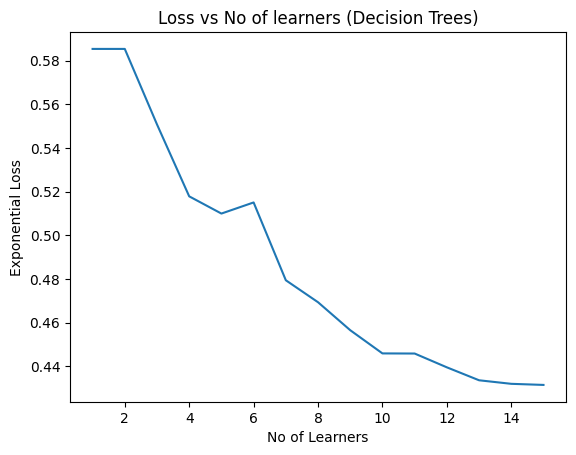

In [ ]:
plt.plot(np.arange(1,16),clf.loss)
plt.xlabel("No of Learners")
plt.ylabel("Exponential Loss")
plt.title("Loss vs No of learners (Decision Trees)")

Text(0.5, 1.0, 'Ensemble Accuracy vs No of learners(Decision Trees)')

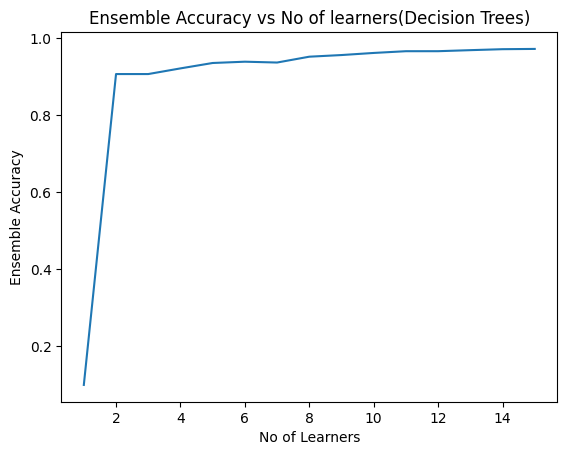

In [ ]:
plt.plot(np.arange(1,16),clf.ensemble_accuracy)
plt.xlabel("No of Learners")
plt.ylabel("Ensemble Accuracy")
plt.title("Ensemble Accuracy vs No of learners(Decision Trees)")

# Test Accuracy

In [ ]:
y_pred_test = clf.predict(Q1_X_test_1)
test_accuracy = np.mean(y_pred_test==Q1_y_test_1)
print("Test Accuracy",test_accuracy)

Test Accuracy 0.9345555555555556


# Neural Networks as Learners

In [ ]:
clf_1 = Adaboost(n_clf=30)
clf_1.fit(Q1_X_train_1, Q1_y_train_1)

Learner:  1
Alpha:  3.779985934312618
Accuracy of current classifier:  0.829595238095238
Exp Loss:  0.7683992003575705
Accuracy of Ensemble classifier till now:  0.1
Learner:  2
Alpha:  2.6948173187683713
Accuracy of current classifier:  0.6431904761904762
Exp Loss:  0.7683992003575705
Accuracy of Ensemble classifier till now:  0.829595238095238
Learner:  3
Alpha:  1.5902921405457628
Accuracy of current classifier:  0.42028571428571426
Exp Loss:  0.7695744015512143
Accuracy of Ensemble classifier till now:  0.829595238095238
Learner:  4
Alpha:  1.6837338050896116
Accuracy of current classifier:  0.4262619047619048
Exp Loss:  0.8486486532949614
Accuracy of Ensemble classifier till now:  0.8290952380952381
Learner:  5
Alpha:  1.190323040304601
Accuracy of current classifier:  0.29014285714285715
Exp Loss:  0.8191007375690601
Accuracy of Ensemble classifier till now:  0.7954523809523809
Learner:  6
Alpha:  1.1644868304378984
Accuracy of current classifier:  0.36652380952380953
Exp Loss:  

Text(0.5, 1.0, 'Loss vs No of learners (Neural Networks)')

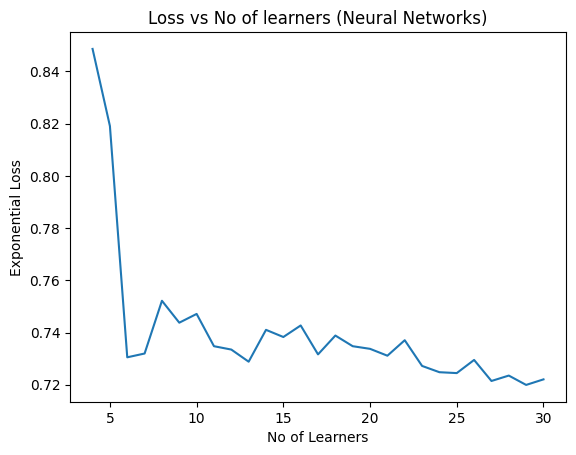

In [ ]:
plt.plot(np.arange(4,31),clf_1.loss[3:])
plt.xlabel("No of Learners")
plt.ylabel("Exponential Loss")
plt.title("Loss vs No of learners (Neural Networks)")

Text(0.5, 1.0, 'Ensemble Accuracy vs No of learners(Neural Networks)')

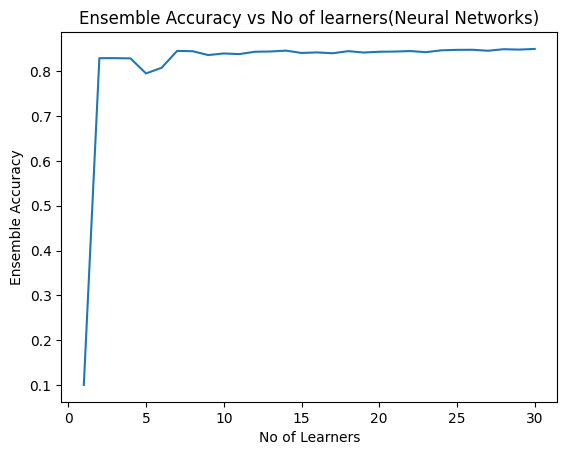

In [ ]:
plt.plot(np.arange(1,31),clf_1.ensemble_accuracy)
plt.xlabel("No of Learners")
plt.ylabel("Ensemble Accuracy")
plt.title("Ensemble Accuracy vs No of learners(Neural Networks)")

# Test Accuracy

In [ ]:
y_pred_test = clf_1.predict(Q1_X_test_1)
test_accuracy = np.mean(y_pred_test==Q1_y_test_1)
print("Test Accuracy",test_accuracy)

Test Accuracy 0.8566666666666667


## Q4

# Distance Metric (L2)

In [ ]:
def distance(x1, x2):
    return np.sum((x1 - x2) ** 2)

# K-MEANS

In [ ]:
class KMeans:
    def __init__(self, K=5, max_iters=100):
        self.K = K
        self.max_iters = max_iters

        # list of sample indices for each cluster
        self.clusters = [[] for _ in range(self.K)]
        # the centers (mean feature vector) for each cluster
        self.centroids = []

    def _closest_centroid(self, sample, centroids):
        # distance of the current sample to each centroid
        distances = [distance(sample, point) for point in centroids]
        closest_index = np.argmin(distances)
        return closest_index

    def _create_clusters(self, centroids):
        # Assign the samples to the closest centroids to create clusters
        clusters = [[] for _ in range(self.K)]
        for idx, sample in enumerate(self.X):
            centroid_idx = self._closest_centroid(sample, centroids)
            clusters[centroid_idx].append(idx)
        return clusters

    def _get_centroids(self, clusters):
        # assign mean value of clusters to centroids
        centroids = np.zeros((self.K, self.n_features))
        for cluster_idx, cluster in enumerate(clusters):
            cluster_mean = np.mean(self.X[cluster], axis=0)
            centroids[cluster_idx] = cluster_mean
        return centroids

    def _get_cluster_labels(self, clusters):
        # each sample will get the label of the cluster it was assigned to
        labels = np.empty(self.n_samples)

        for cluster_idx, cluster in enumerate(clusters):
            for sample_index in cluster:
                labels[sample_index] = cluster_idx
        return labels

    def _is_converged(self, centroids_old, centroids):
        # distances between each old and new centroids, fol all centroids
        distances = [
            distance(centroids_old[i], centroids[i]) for i in range(self.K)
        ]
        return sum(distances) == 0


    def predict(self, X):
        self.X = X
        self.n_samples, self.n_features = X.shape

        # initialize
        random_sample_idxs = np.random.choice(self.n_samples, self.K, replace=False)
        self.centroids = [self.X[idx] for idx in random_sample_idxs]

        # Optimize clusters
        for _ in range(self.max_iters):
            # Assign samples to closest centroids (create clusters)
            self.clusters = self._create_clusters(self.centroids)

            # Calculate new centroids from the clusters
            centroids_old = self.centroids
            self.centroids = self._get_centroids(self.clusters)
            
            # check if clusters have changed
            if self._is_converged(centroids_old, self.centroids):
                break
        
        # Classify samples as the index of their clusters
        return self._get_cluster_labels(self.clusters)

# GMM Clustering

In [ ]:
class Gaussian_Mixture_Model:
    
    def __init__(self,mixtures):
        self.mixtures = mixtures
        self.feature_dimension = None
        self.means = None
        #self.cov = None
        self.alpha = np.ones(self.mixtures)/self.mixtures

    def __Initialize_parameters(self):
        self.means = []
        self.cov = []
        for j in range(self.mixtures):
            self.means.append(np.random.random_sample((self.feature_dimension)))
            #self.cov.append(np.eye(self.feature_dimension)))

    def __gaussian(self,x,mean):   
        z = x - mean
        return np.exp(-0.5*z@z.T)
     
    def __update_mean(self,data,gamma,n_j):
        N = data.shape[0]
        sum = 0
        for i in range(N):
            sum += gamma[i]*data[i]
        return sum/n_j
    
    
    def __EM_update(self,data,epochs):
        num_data_points = data.shape[0]
        gamma = []
        for i in range(self.mixtures):
            temp = np.zeros(num_data_points)
            gamma.append(temp)
        
        for i in range(epochs):
            for k in range(num_data_points):
                temp2 = np.zeros(self.mixtures)
                for l in range(self.mixtures):
                    gauss = self.__gaussian(data[k],self.means[l])                  
                    temp2[l] = gauss
                temp2  = temp2*self.alpha
                for l in range(self.mixtures):
                  gamma[l][k] = temp2[l]/np.sum(temp2)
            
            for j in range(self.mixtures):                
                n_j = np.sum(gamma[j])
                self.means[j] = self.__update_mean(data,gamma[j],n_j)
                self.alpha[j] = n_j/num_data_points
    
    def predict(self,X,epochs):
        self.feature_dimension = X.shape[1]
        self.__Initialize_parameters()
        self.__EM_update(X,epochs)
        probs = np.zeros((X.shape[0], self.mixtures))
        for i in range(X.shape[0]):
            for j in range(self.mixtures):
                probs[i, j] = self.alpha[j] *self.__gaussian(X[i],self.means[j])

        # Predict the cluster assignments
        return np.argmax(probs, axis=1)

# NMI

In [ ]:
def mutual_information(labels_true, labels_pred):
    # Compute the contingency table
    contingency = np.zeros((len(np.unique(labels_true)), len(np.unique(labels_pred))))
    for i, j in zip(labels_true, labels_pred):
        contingency[i.astype(int), j.astype(int)] += 1

    # Compute the marginal sums over rows and columns
    sum_rows = np.sum(contingency, axis=1)
    sum_cols = np.sum(contingency, axis=0)

    # Compute the total number of samples
    N = np.sum(sum_rows)

    # Compute the entropy of the true labels and predicted labels
    H_true = -np.sum((sum_rows / N) * np.log2(sum_rows / N))
    H_pred = -np.sum((sum_cols / N) * np.log2(sum_cols / N))

    # Compute the mutual information
    mi = 0.0
    for i in range(contingency.shape[0]):
        for j in range(contingency.shape[1]):
            if contingency[i, j] > 0:
                mi += (contingency[i, j] / N) * np.log2((contingency[i, j] * N) / (sum_rows[i] * sum_cols[j]))

    return mi, H_true, H_pred


def normalized_mutual_information(labels_true, labels_pred):
    # Compute the mutual information, entropy of true labels, and entropy of predicted labels
    mi, H_true, H_pred = mutual_information(labels_true, labels_pred)

    # Compute the normalized mutual information
    nmi = (2.0 * mi) / (H_true + H_pred)

    return nmi

# Importing Dataseta and preprocessing

In [ ]:
kmnist = np.genfromtxt("/content/drive/MyDrive/PRNN/A1/Kmnist.csv", delimiter=",", dtype=float)

In [ ]:
# kmnist[:,0:-1] = (kmnist[:,0:-1]-127.5)/127.5
kmnist[:,0:-1] = (kmnist[:,0:-1])/255

In [ ]:
X = kmnist[:,0:-1]
y = kmnist[:,-1]

# Kmeans on KMNIST

In [ ]:
def fun_kmeans(K):
    mni = []
    for i in range(1,K+1):
        model = KMeans(K = i,max_iters = 50)
        pred = model.predict(X)
        mni.append(normalized_mutual_information(y,pred))
    return mni

In [ ]:
mni = fun_kmeans(15)

Text(0.5, 1.0, 'NMI vs Number of clusters(KMEANS)')

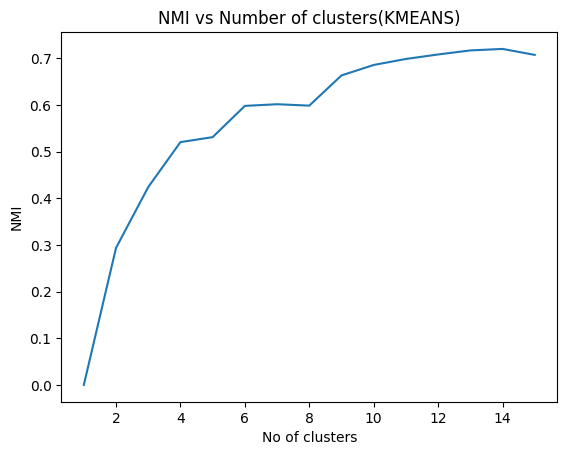

In [ ]:
plt.plot(np.arange(1,16),mni)
plt.xlabel("No of clusters")
plt.ylabel("NMI")
plt.title("NMI vs Number of clusters(KMEANS)")


# GMM Clustering on KMNIST

In [ ]:
def fun_GMM(K):
    mni = []
    for i in range(1,K+1):
        model = Gaussian_Mixture_Model(i)
        pred = model.predict(X,30)
        mni.append(normalized_mutual_information(y,pred))
    return mni

In [ ]:
mni_gmm = fun_GMM(15)

Text(0.5, 1.0, 'NMI vs No of Clusters(GMM)')

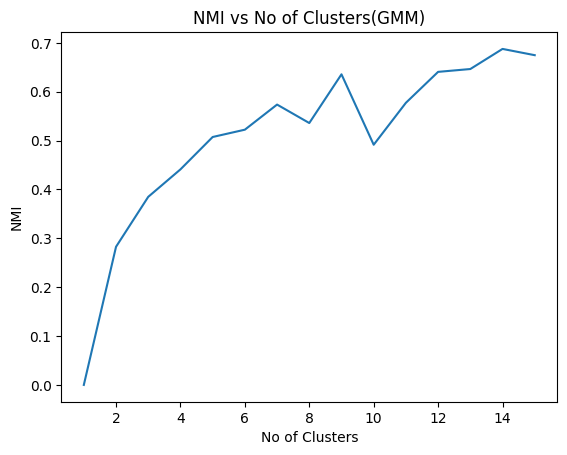

In [ ]:
plt.plot(np.arange(1,16),mni_gmm)
plt.xlabel("No of Clusters")
plt.ylabel("NMI")
plt.title("NMI vs No of Clusters(GMM)")

# TSNE Plots

In [ ]:
# Perform t-SNE on the data
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)



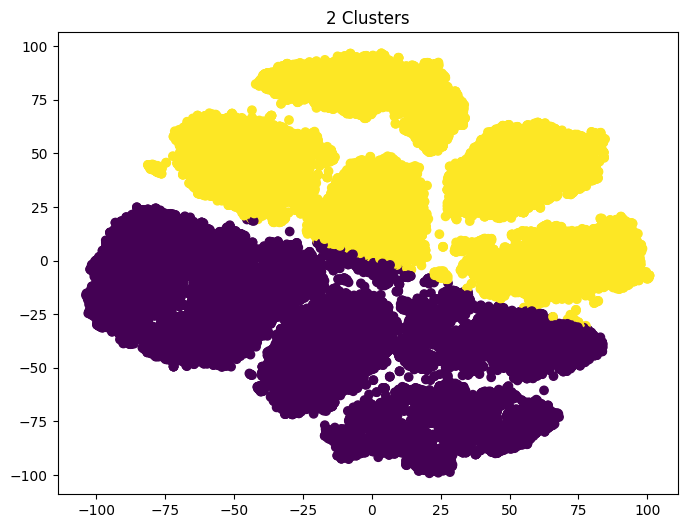

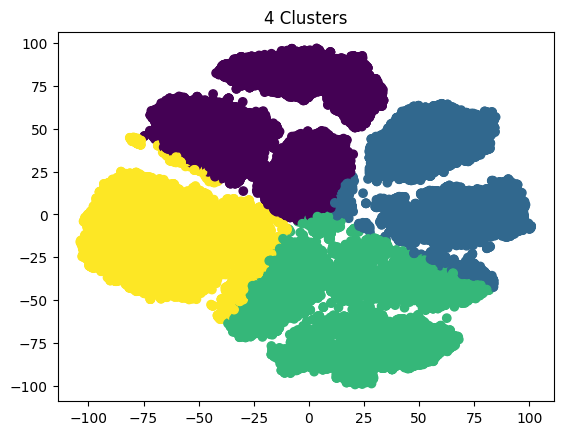

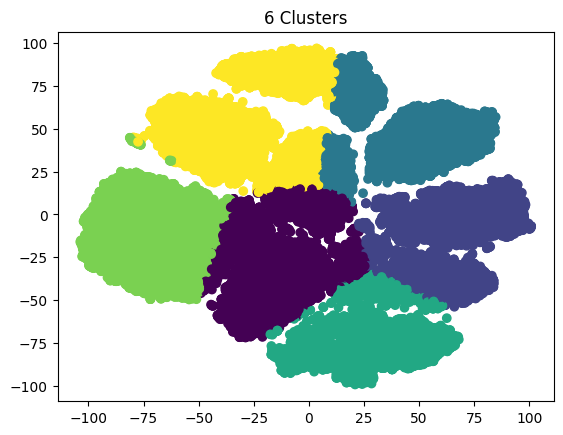

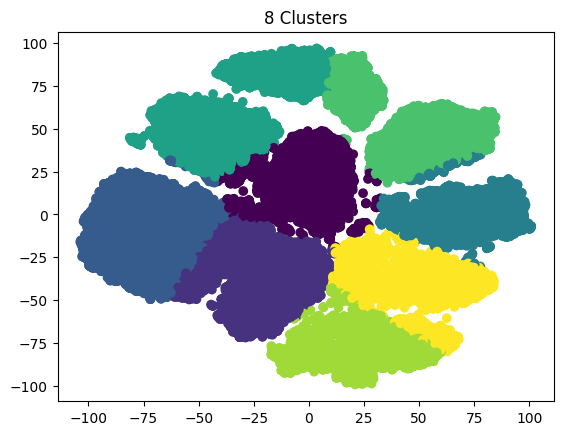

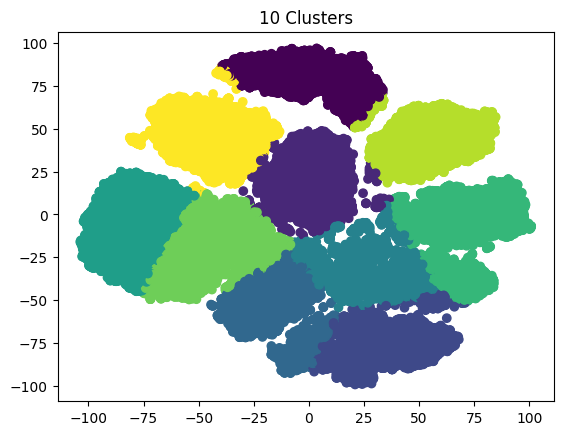

In [ ]:
# Define the number of clusters to use
num_clusters = [2,4,6,8,10]

# Create a figure to hold the plots
fig = plt.figure(figsize=(8,6))

# Loop over the number of clusters and create a plot for each
for i, n_clusters in enumerate(num_clusters):
    # Perform k-means clustering on the t-SNE features
    kmeans = KMeans(K=n_clusters, max_iters = 20)
    labels = kmeans.predict(X_tsne)
    
    # Plot the t-SNE features colored by the cluster labels
    plt.scatter(X_tsne[:,0], X_tsne[:,1], c=labels, cmap='viridis')
    plt.title(f"{n_clusters} Clusters")
    plt.show()

## Q5

In [ ]:
class PCA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.components = None
        self.mean = None

    def fit(self, X):
        # Mean centering
        self.mean = np.mean(X, axis=0)
        X = X - self.mean

        # covariance, function needs samples as columns
        cov = np.cov(X.T)

        # eigenvalues, eigenvectors
        eigenvalues, eigenvectors = np.linalg.eig(cov)

        # -> eigenvector v = [:,i] column vector, transpose for easier calculations
        # sort eigenvectors
        eigenvectors = eigenvectors.T
        idxs = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idxs]
        eigenvectors = eigenvectors[idxs]

        # store first n eigenvectors
        self.components = eigenvectors[0 : self.n_components]

        # Explained variance ratio
        self.explained_variance_ratio = [i/np.sum(eigenvalues) for i in eigenvalues[:self.n_components]]
        # self.explained_variance_ratio = [i/np.sum(eigenvalues) for i in eigenvalues[:self.n_components]]
        
        self.cum_explained_variance = np.cumsum(self.explained_variance_ratio)


    def transform(self, X):
        # project data
        X = X - self.mean
        return np.dot(X, self.components.T)

In [ ]:
kmnist = np.genfromtxt("/content/drive/MyDrive/PRNN/Kmnist.csv", delimiter=",", dtype=float)

In [ ]:
obj_p = PCA(784)

In [ ]:
obj_p.fit(kmnist[:, :-1])

Text(0.5, 1.0, 'Data Variance vs Principal Component')

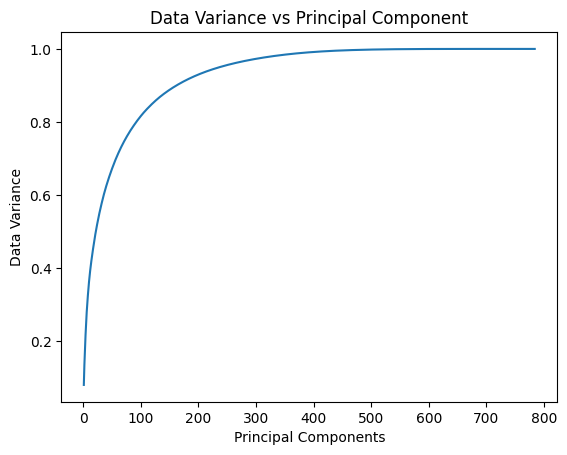

In [ ]:
plt.plot(np.arange(1,785),obj_p.cum_explained_variance)
# plt.xlim([1,15])
plt.xlabel("Principal Components")
plt.ylabel("Data Variance")
plt.title("Data Variance vs Principal Component")

In [ ]:
obj_p.cum_explained_variance[4]

(0.251134959445136+0j)